In [72]:
# =======================================
# DeepRacer Simple Log Visualization
# =======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [43]:
# --- Load CSV ---
# replace main_dir with github repo directory
main_dir = "/Users/johannmai/Desktop/Nga/42Horsepower"
track_dir = "tracks"
eval_log_dir = os.path.join(main_dir, "eval_log/")
training_log_dir = os.path.join(main_dir, "training_log/")
#data from csv
df = pd.read_csv(os.path.join(log_dir, "test1/sim-trace/evaluation/20250812104443-h1lswyHIQcOGQ8_aIWgwAQ/evaluation-simtrace/0-iteration.csv"))

#track waypoints
track_file = os.path.join(main_dir, track_dir, "2024_reinvent_champ_ccw.npy")

In [39]:
# --- Derived metrics ---
df["speed"] = df["throttle"]  # If throttle directly maps to speed (adjust if you have actual m/s)
# If throttle is gear-like instead of real m/s, you might need: df["speed"] = df["throttle"] * speed_scale
df["episode"] = df["episode"].astype(int)

In [78]:
waypoints = np.load(track_file, allow_pickle=True)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
print("Is loop/ring? ", l_center_line.is_ring)

Is loop/ring?  True


In [70]:
def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [71]:
## Function to calculate the ideal race line
import copy

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [79]:
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print(".")

/var/folders/4w/bnnqyjz102v7njfpr32s_2580000gn/T/ipykernel_34902/3077679682.py:9: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))


Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980


These should be the same:  ((86, 2), (86, 2))
Original centerline length: 25.11
New race line length: 22.49


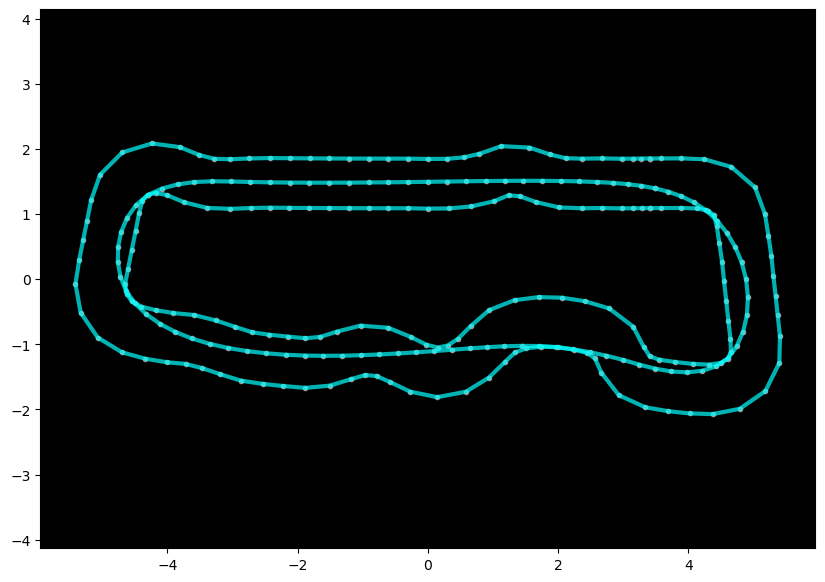

In [85]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(10, 7))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

In [47]:
def plot_track(npy_file):
    """
    Visualize a DeepRacer track from an .npy file.
    
    Parameters
    ----------
    npy_file : str
        Path to the .npy file containing track data
    show_borders : bool
        If True, also plot left/right borders (if available)
    """
    track_data = np.load(npy_file, allow_pickle=True)

    center_line = np.array(track_data[:, 0 : 2])
    left_line = np.array(track_data[:, 2 : 4])
    right_line = np.array(track_data[:, 4 : 6])
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(left_line[:, 0], left_line[:, 1], 'k--', label="Left Border")
    ax.plot(right_line[:, 0], right_line[:, 1], 'k--', label="Right Border")
    
    ax.scatter(center_line[:, 0], center_line[:, 1], s=10, c="green", label="Waypoints")
    ax.axis("equal")

    return fig, ax

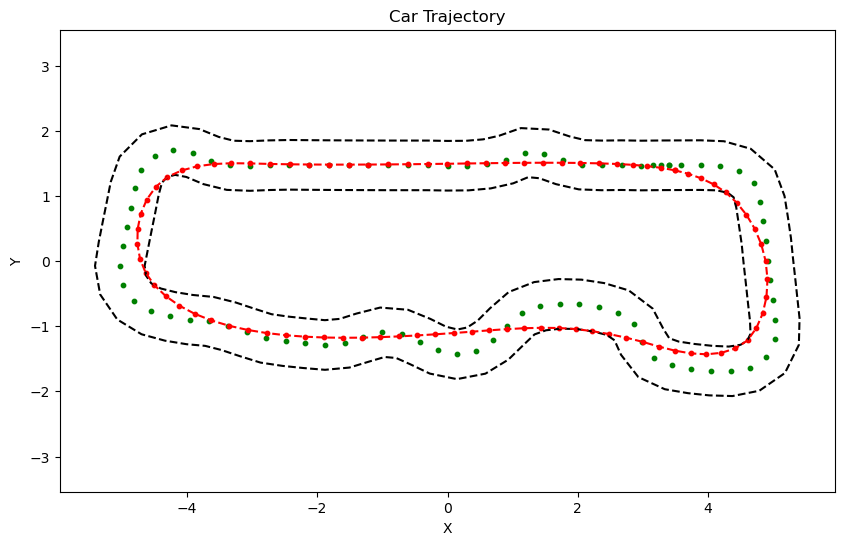

In [86]:
# --- 1. Plot Waypoints / Trajectory ---
fig, ax = plot_track(track_file)
ax.scatter(loop_race_line[:, 0], loop_race_line[:, 1], s=10, c="red", label="ideal")
ax.plot(loop_race_line[:, 0], loop_race_line[:, 1], 'r--', label="ideal line")

#ax.plot(df["X"], df["Y"], marker="o", markersize=2, linestyle="-", alpha=0.7)
plt.title("Car Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [87]:
loop_race_line

array([[ 3.48527602e+00,  1.39515945e+00],
       [ 3.27787335e+00,  1.43259221e+00],
       [ 3.06481037e+00,  1.45931525e+00],
       [ 2.84149704e+00,  1.47826027e+00],
       [ 2.59854854e+00,  1.49176047e+00],
       [ 2.32381710e+00,  1.50117582e+00],
       [ 2.04167648e+00,  1.50702217e+00],
       [ 1.75563933e+00,  1.50995011e+00],
       [ 1.46692807e+00,  1.51050151e+00],
       [ 1.17626000e+00,  1.50921124e+00],
       [ 8.84139253e-01,  1.50658572e+00],
       [ 5.91033246e-01,  1.50309876e+00],
       [ 2.97378160e-01,  1.49915037e+00],
       [-4.57222222e-03,  1.49476358e+00],
       [-3.06674254e-01,  1.49080696e+00],
       [-6.08939300e-01,  1.48738555e+00],
       [-9.11369557e-01,  1.48462140e+00],
       [-1.21395244e+00,  1.48265416e+00],
       [-1.51665706e+00,  1.48164319e+00],
       [-1.81943488e+00,  1.48177282e+00],
       [-2.12222156e+00,  1.48331589e+00],
       [-2.42493029e+00,  1.48660224e+00],
       [-2.72744319e+00,  1.49198466e+00],
       [-3.

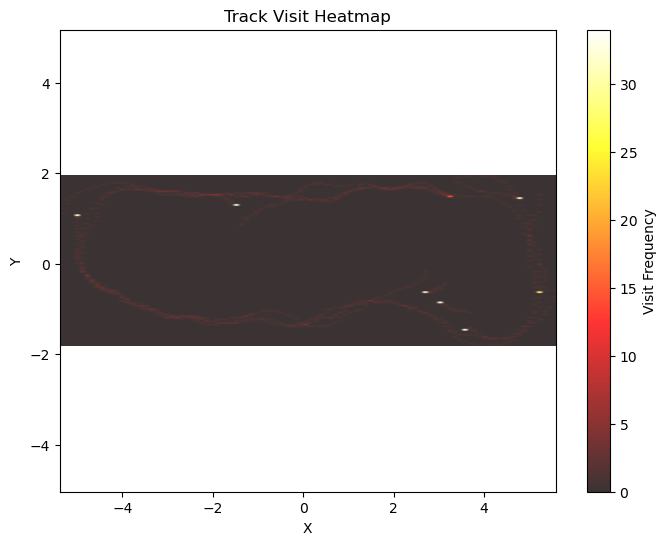

In [45]:
# --- 2. Heatmap of Track Visits ---
fig, ax = plot_track(track_file)
heatmap, xedges, yedges = np.histogram2d(df["X"], df["Y"], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.8)
plt.colorbar(label="Visit Frequency")
plt.title("Track Visit Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

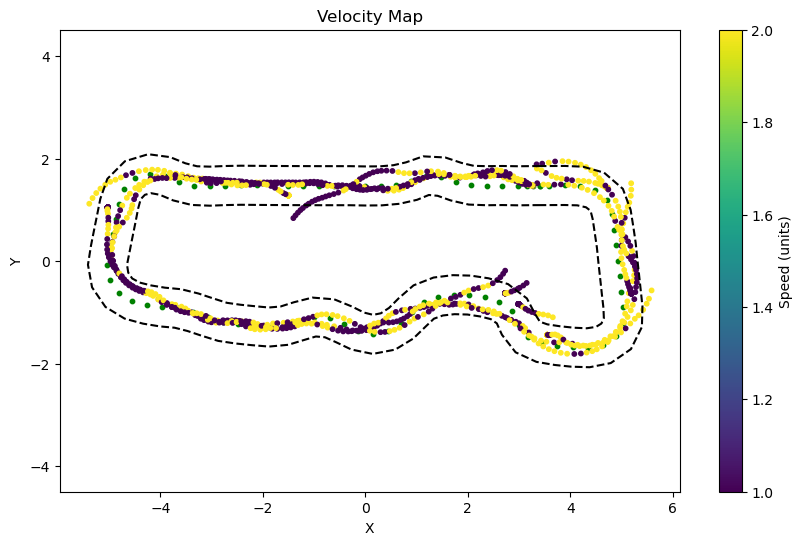

In [7]:
# --- 3. Velocity Map ---
fig, ax = plot_track(track_file)
sc = ax.scatter(df["X"], df["Y"], c=df["speed"], cmap="viridis", s=10)
fig.colorbar(sc, label="Speed (units)")
plt.title("Velocity Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

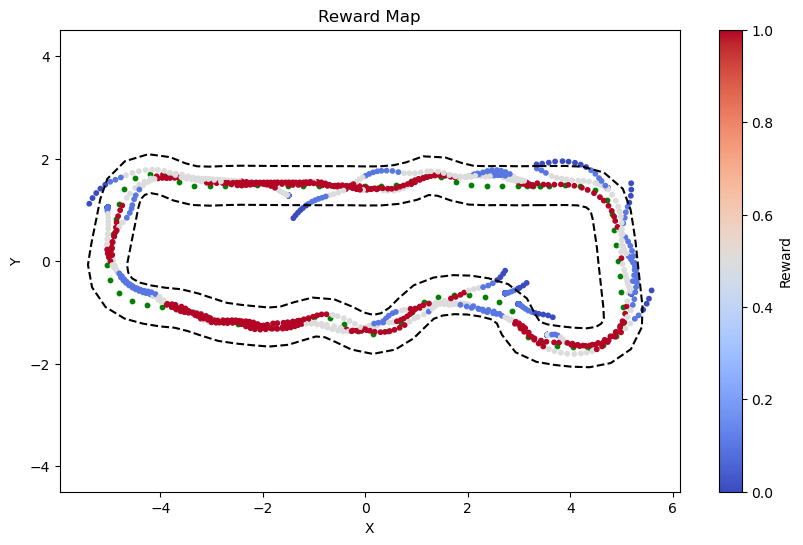

In [53]:
# --- 4. Reward Map ---
fig, ax = plot_track(track_file)
sc = ax.scatter(df["X"], df["Y"], c=df["reward"], cmap="coolwarm", s=10)
fig.colorbar(sc, label="Reward")
plt.title("Reward Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

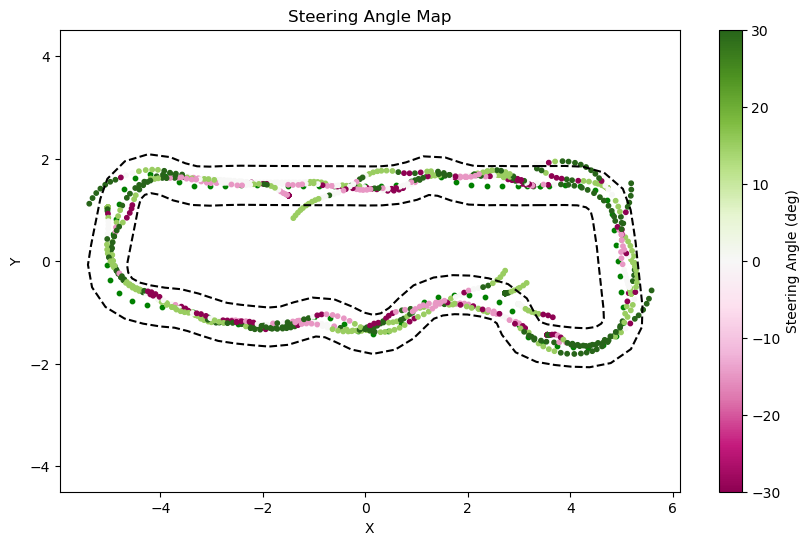

In [54]:
# =======================================
# 5. Steering Angle Map
# =======================================
fig, ax = plot_track(track_file)
sc = ax.scatter(df["X"], df["Y"], c=df["steer"], cmap="PiYG", s=10)
fig.colorbar(sc, label="Steering Angle (deg)")
plt.title("Steering Angle Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

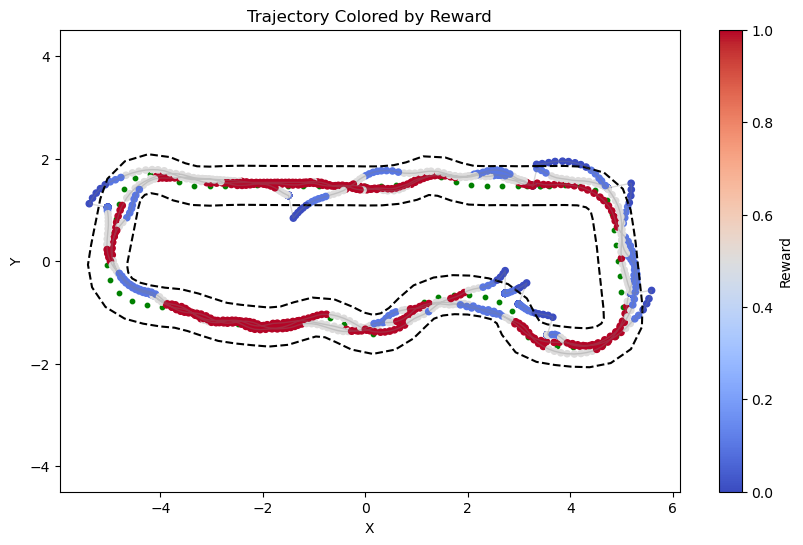

In [55]:
# =======================================
# 6. Reward Density Overlay on Trajectory
# =======================================
fig, ax = plot_track(track_file)
ax.plot(df["X"], df["Y"], color='grey', alpha=0.3, linestyle='-', linewidth=1)
sc = ax.scatter(df["X"], df["Y"], c=df["reward"], cmap="coolwarm", s=20)
fig.colorbar(sc, label="Reward")
plt.title("Trajectory Colored by Reward")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

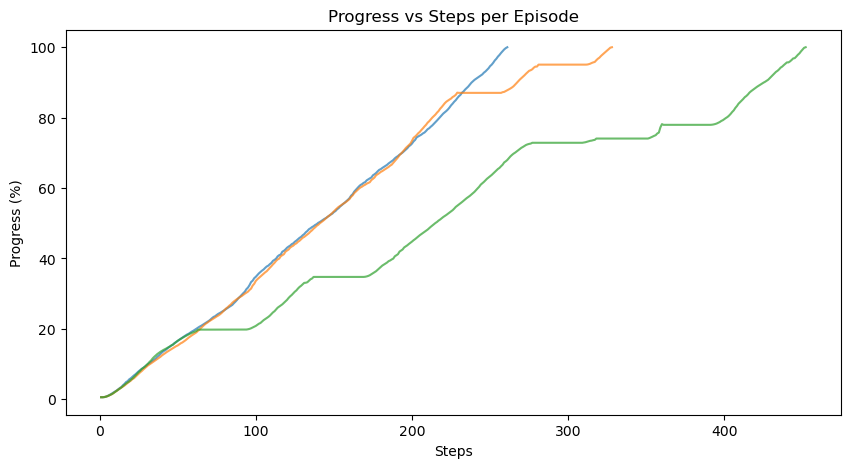

In [50]:
# =======================================
# 7. Episode-by-Episode Progress
# =======================================
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="steps", y="progress", hue="episode", palette="tab10", alpha=0.7, legend=False)
plt.title("Progress vs Steps per Episode")
plt.xlabel("Steps")
plt.ylabel("Progress (%)")
plt.show()